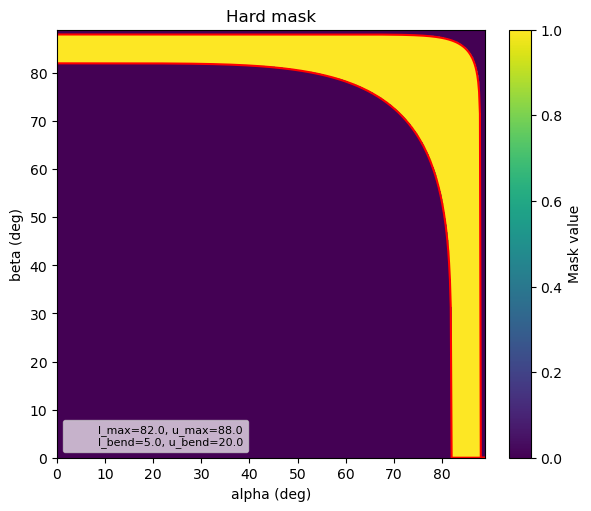

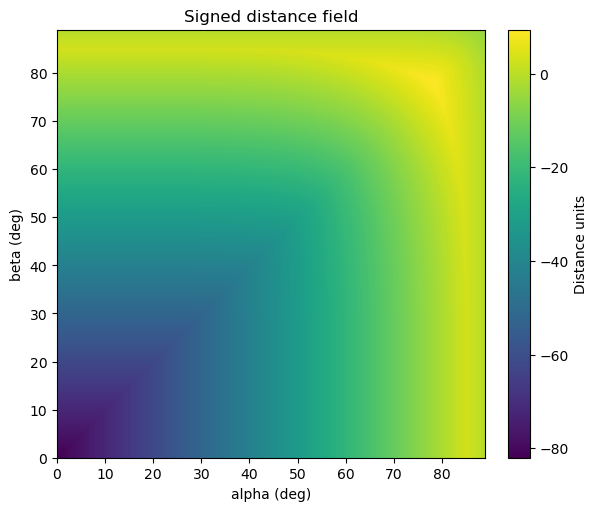

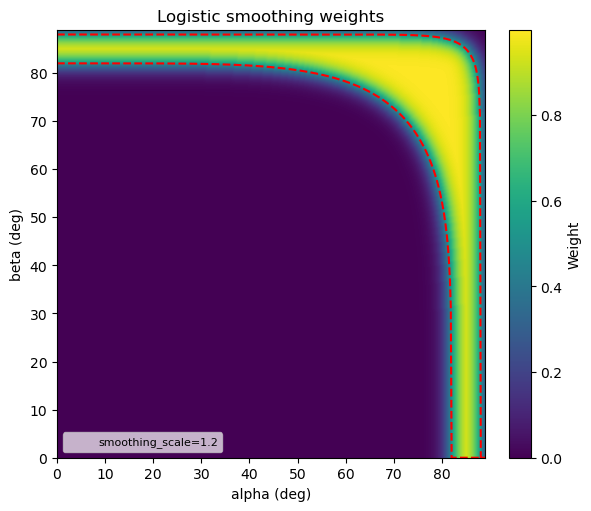

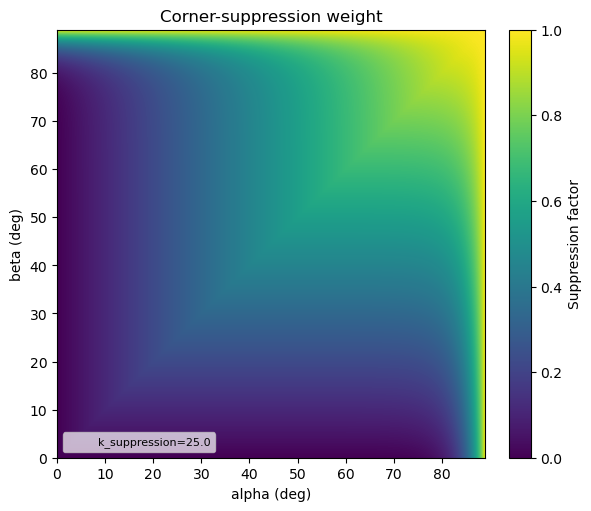

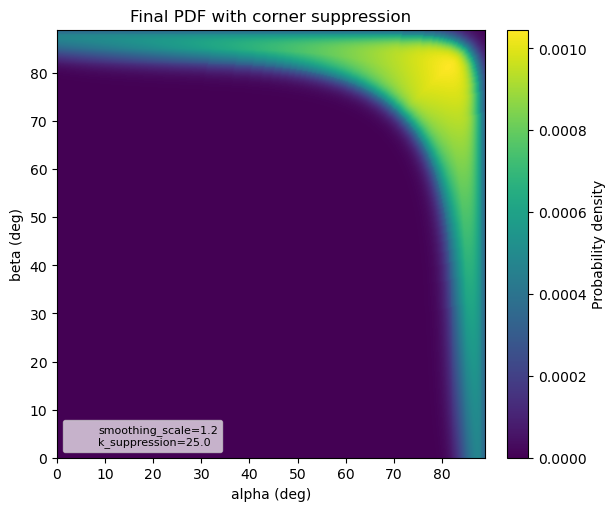

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from matplotlib.lines import Line2D

# parameters and grid
l_max, u_max = 82.0, 88.0
l_bend, u_bend = 5.0, 20.0
smoothing_scale = 1.2
k_suppression = 25.0

n = 500
x = np.linspace(0, 89, n)
y = np.linspace(0, 89, n)
X, Y = np.meshgrid(x, y, indexing="xy")


# Lower and upper curves
def lower_curve(t):
    r = np.clip(t / l_max, 0, 1)
    return l_max * (1 - r**l_bend) ** (1 / l_bend)


def upper_curve(t):
    r = np.clip(t / u_max, 0, 1)
    return u_max * (1 - r**u_bend) ** (1 / u_bend)


# Hard mask (indicator function for the region)
mask = (Y >= lower_curve(X)) & (Y <= upper_curve(X)) & (X >= lower_curve(Y)) & (X <= upper_curve(Y))

# Signed distance field
dx = x[1] - x[0]
dy = y[1] - y[0]
dist_in = distance_transform_edt(mask, sampling=(dy, dx))
dist_out = distance_transform_edt(~mask, sampling=(dy, dx))
signed_dist = dist_in - dist_out

# Logistic smoothing
weights = 1.0 / (1.0 + np.exp(-signed_dist / smoothing_scale))

# build the corner-suppression weight
alpha_norm = X / X.max()
beta_norm = Y / Y.max()
small = np.minimum(alpha_norm, beta_norm)
large = np.maximum(alpha_norm, beta_norm)
suppression = small + (1 - small) * (large**k_suppression)

# apply suppression, re-normalize to a proper PDF
w2 = weights * suppression
area2 = np.trapz(np.trapz(w2, y, axis=0), x)
pdf2 = w2 / area2

# Dummy handle for legends
dummy = Line2D([], [], linestyle="None")

# Plot 1: Hard mask
fig1, ax1 = plt.subplots(figsize=(6, 5), constrained_layout=True)
im1 = ax1.imshow(mask.astype(float), extent=[0, 89, 0, 89], origin="lower", aspect="equal")
ax1.plot(x, upper_curve(x), "r", label="upper\_curve")
ax1.plot(x, lower_curve(x), "r", label="lower\_curve")
ax1.set_title("Hard mask")
ax1.set_xlabel("alpha (deg)")
ax1.set_ylabel("beta (deg)")
legend_text = f"l_max={l_max}, u_max={u_max}\nl_bend={l_bend}, u_bend={u_bend}"
ax1.legend([dummy], [legend_text], loc="lower left", framealpha=0.7, fontsize=8)
plt.colorbar(im1, ax=ax1, label="Mask value")
plt.show()

# Plot 2: Signed distance field 
fig2, ax2 = plt.subplots(figsize=(6, 5), constrained_layout=True)
im2 = ax2.imshow(signed_dist, extent=[0, 89, 0, 89], origin="lower", aspect="equal")
ax2.set_title("Signed distance field")
ax2.set_xlabel("alpha (deg)")
ax2.set_ylabel("beta (deg)")
plt.colorbar(im2, ax=ax2, label="Distance units")
plt.show()

# Plot 3: Logistic smoothing weights
fig3, ax3 = plt.subplots(figsize=(6, 5), constrained_layout=True)
im3 = ax3.imshow(weights, extent=[0, 89, 0, 89], origin="lower", aspect="equal")
ax3.plot(x, upper_curve(x), "r--", label="upper\_curve")
ax3.plot(x, lower_curve(x), "r--", label="lower\_curve")
ax3.set_title("Logistic smoothing weights")
ax3.set_xlabel("alpha (deg)")
ax3.set_ylabel("beta (deg)")
legend_text = f"smoothing_scale={smoothing_scale}"
ax3.legend([dummy], [legend_text], loc="lower left", framealpha=0.7, fontsize=8)
plt.colorbar(im3, ax=ax3, label="Weight")
plt.show()

# Plot 4: Corner-suppression weight
fig4, ax4 = plt.subplots(figsize=(6, 5), constrained_layout=True)
im4 = ax4.imshow(suppression, extent=[0, 89, 0, 89], origin="lower", aspect="equal")
ax4.set_title("Corner-suppression weight")
ax4.set_xlabel("alpha (deg)")
ax4.set_ylabel("beta (deg)")
legend_text = f"k_suppression={k_suppression}"
ax4.legend([dummy], [legend_text], loc="lower left", framealpha=0.7, fontsize=8)
plt.colorbar(im4, ax=ax4, label="Suppression factor")
plt.show()

# Plot 5: Final PDF with corner suppression
fig5, ax5 = plt.subplots(figsize=(6, 5), constrained_layout=True)
im5 = ax5.imshow(pdf2, extent=[0, 89, 0, 89], origin="lower", aspect="equal")
ax5.set_title("Final PDF with corner suppression")
ax5.set_xlabel("alpha (deg)")
ax5.set_ylabel("beta (deg)")
legend_text = f"smoothing_scale={smoothing_scale}\nk_suppression={k_suppression}"
ax5.legend([dummy], [legend_text], loc="lower left", framealpha=0.7, fontsize=8)
plt.colorbar(im5, ax=ax5, label="Probability density")
plt.show()

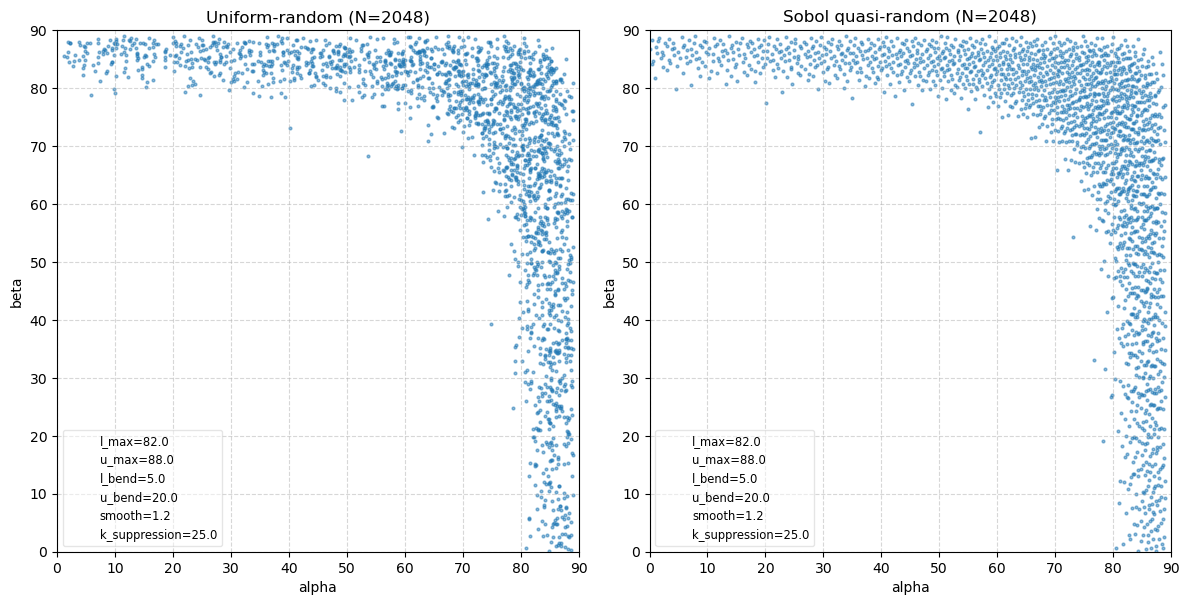

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.stats import qmc

# parameters
l_max, u_max = 82.0, 88.0
l_bend, u_bend = 5.0, 20.0
smooth = 1.2
k_suppression = 25.0
N = 2048

# grid
n = 500
x = np.linspace(0, 89, n)
y = np.linspace(0, 89, n)
X, Y = np.meshgrid(x, y, indexing="xy")


# curves
def lower_curve(t):
    r = np.clip(t / l_max, 0, 1)
    return l_max * (1 - r**l_bend) ** (1 / l_bend)


def upper_curve(t):
    r = np.clip(t / u_max, 0, 1)
    return u_max * (1 - r**u_bend) ** (1 / u_bend)


# base PDF weights via signed-distance + logistic
mask = (Y >= lower_curve(X)) & (Y <= upper_curve(X)) & (X >= lower_curve(Y)) & (X <= upper_curve(Y))
dx, dy = x[1] - x[0], y[1] - y[0]
dist_in = distance_transform_edt(mask, sampling=(dy, dx))
dist_out = distance_transform_edt(~mask, sampling=(dy, dx))
signed_d = dist_in - dist_out
weights = 1.0 / (1.0 + np.exp(-signed_d / smooth))

# corner suppression
alpha_norm = X / X.max()
beta_norm = Y / Y.max()
small = np.minimum(alpha_norm, beta_norm)
large = np.maximum(alpha_norm, beta_norm)
suppression = 1 - (1 - small) * (1 - large**k_suppression)
weights *= suppression

# normalize to PDF
area = np.trapz(np.trapz(weights, y, axis=0), x)
pdf = weights / area

# precompute CDFs for sampling
f_x = np.trapz(pdf, y, axis=0)
cdf_x = np.cumsum(f_x) * dx
cdf_x /= cdf_x[-1]

cdf_y = np.cumsum(pdf, axis=0) * dy
cdf_y /= cdf_y[-1, :]

# uniform random sampling
np.random.seed(42)
u1 = np.random.rand(N)
ix = np.searchsorted(cdf_x, u1, side="right")
x_mc = x[ix]
u2 = np.random.rand(N)
y_mc = np.array([np.interp(u2[i], cdf_y[:, ix[i]], y) for i in range(N)])

# Sobol quasi-random sampling
sobol = qmc.Sobol(d=2, scramble=True, seed=42)
u_sobol = sobol.random(N)
ix_s = np.searchsorted(cdf_x, u_sobol[:, 0], side="right")
x_sobol = x[ix_s]
y_sobol = np.array([np.interp(u_sobol[i, 1], cdf_y[:, ix_s[i]], y) for i in range(N)])

# plot samples
params = {
    "l_max": l_max,
    "u_max": u_max,
    "l_bend": l_bend,
    "u_bend": u_bend,
    "smooth": smooth,
    "k_suppression": k_suppression,
}

plt.figure(figsize=(12, 6))
for i, (xs, ys, title) in enumerate(
    [(x_mc, y_mc, f"Uniform-random (N={N})"), (x_sobol, y_sobol, f"Sobol quasi-random (N={N})")], 1
):
    ax = plt.subplot(1, 2, i)
    ax.scatter(xs, ys, s=4, alpha=0.5)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 90)
    ax.set_aspect("equal")
    ax.set_xlabel("alpha")
    ax.set_ylabel("beta")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)
    for k, v in params.items():
        ax.plot([], [], " ", label=f"{k}={v}")
    ax.legend(loc="lower left", fontsize="small", framealpha=0.5)

plt.tight_layout()
plt.show()


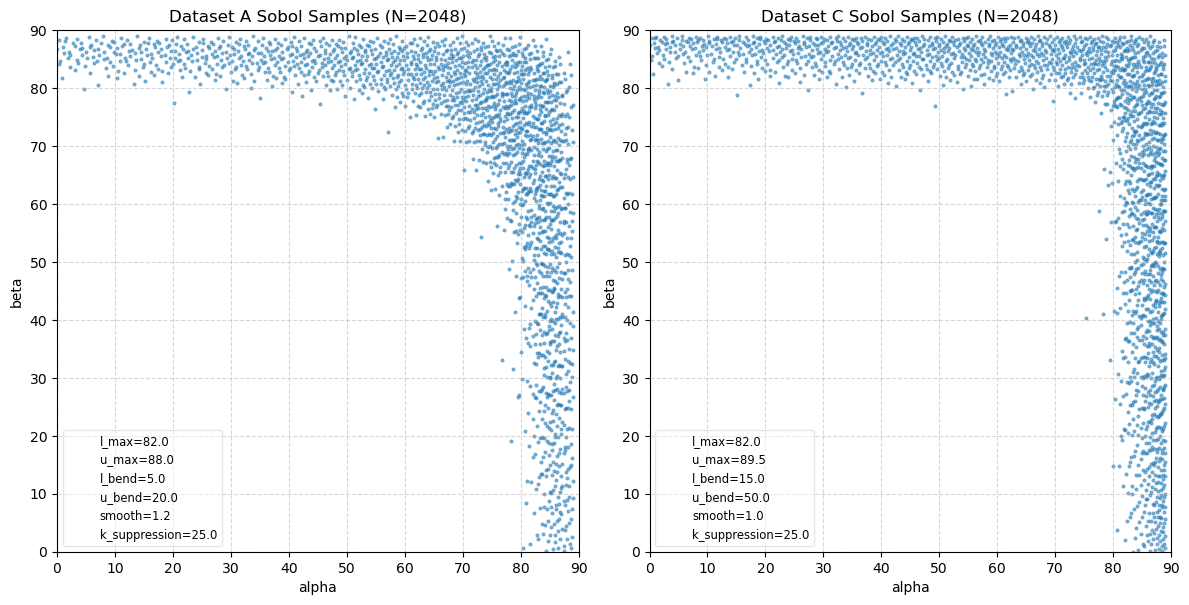

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.stats import qmc


def sample_sobol_from_pdf(params, N=2048, seed=42):
    # Unpack parameters
    l_max, u_max = params["l_max"], params["u_max"]
    l_bend, u_bend = params["l_bend"], params["u_bend"]
    smooth, k_suppression = params["smooth"], params["k_suppression"]

    # Set up grid
    n = 500
    x = np.linspace(0, 89, n)
    y = np.linspace(0, 89, n)
    X, Y = np.meshgrid(x, y, indexing="xy")
    dx, dy = x[1] - x[0], y[1] - y[0]

    # Define superellipse curves
    def lower_curve(t):
        r = np.clip(t / l_max, 0, 1)
        return l_max * (1 - r**l_bend) ** (1 / l_bend)

    def upper_curve(t):
        r = np.clip(t / u_max, 0, 1)
        return u_max * (1 - r**u_bend) ** (1 / u_bend)

    # Compute signed distance field
    mask = (Y >= lower_curve(X)) & (Y <= upper_curve(X)) & (X >= lower_curve(Y)) & (X <= upper_curve(Y))
    dist_in = distance_transform_edt(mask, sampling=(dy, dx))
    dist_out = distance_transform_edt(~mask, sampling=(dy, dx))
    signed_d = dist_in - dist_out

    # Logistic smoothing and suppression
    weights = 1.0 / (1.0 + np.exp(-signed_d / smooth))
    alpha_norm = X / X.max()
    beta_norm = Y / Y.max()
    small = np.minimum(alpha_norm, beta_norm)
    large = np.maximum(alpha_norm, beta_norm)
    suppression = 1 - (1 - small) * (1 - large**k_suppression)
    weights *= suppression

    # Normalize to PDF
    area = np.trapz(np.trapz(weights, y, axis=0), x)
    pdf = weights / area

    # Precompute CDFs
    f_x = np.trapz(pdf, y, axis=0)
    cdf_x = np.cumsum(f_x) * dx
    cdf_x /= cdf_x[-1]
    cdf_y = np.cumsum(pdf, axis=0) * dy
    cdf_y /= cdf_y[-1, :]

    # Sobol sampling in 2D
    sobol = qmc.Sobol(d=2, scramble=True, seed=seed)
    u_sobol = sobol.random(N)
    ix_s = np.searchsorted(cdf_x, u_sobol[:, 0], side="right")
    x_sobol = x[ix_s]
    y_sobol = np.array([np.interp(u_sobol[i, 1], cdf_y[:, ix_s[i]], y) for i in range(N)])
    return x_sobol, y_sobol


# Dataset parameter sets
params_A = {"l_max": 82.0, "u_max": 88.0, "l_bend": 5.0, "u_bend": 20.0, "smooth": 1.2, "k_suppression": 25.0}
params_C = {"l_max": 82.0, "u_max": 89.5, "l_bend": 15.0, "u_bend": 50.0, "smooth": 1.0, "k_suppression": 25.0}

# Generate samples
N = 2048
xs_A, ys_A = sample_sobol_from_pdf(params_A, N)
xs_C, ys_C = sample_sobol_from_pdf(params_C, N)

# Plotting
plt.figure(figsize=(12, 6))

# Dataset A plot
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(xs_A, ys_A, s=4, alpha=0.5)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_aspect("equal")
ax1.set_xlabel("alpha")
ax1.set_ylabel("beta")
ax1.set_title("Dataset A Sobol Samples (N=2048)")
ax1.grid(True, linestyle="--", alpha=0.5)
for k, v in params_A.items():
    ax1.plot([], [], " ", label=f"{k}={v}")
ax1.legend(loc="lower left", fontsize="small", framealpha=0.5)

# Dataset C plot
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(xs_C, ys_C, s=4, alpha=0.5)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 90)
ax2.set_aspect("equal")
ax2.set_xlabel("alpha")
ax2.set_ylabel("beta")
ax2.set_title("Dataset C Sobol Samples (N=2048)")
ax2.grid(True, linestyle="--", alpha=0.5)
for k, v in params_C.items():
    ax2.plot([], [], " ", label=f"{k}={v}")
ax2.legend(loc="lower left", fontsize="small", framealpha=0.5)

plt.tight_layout()
plt.show()

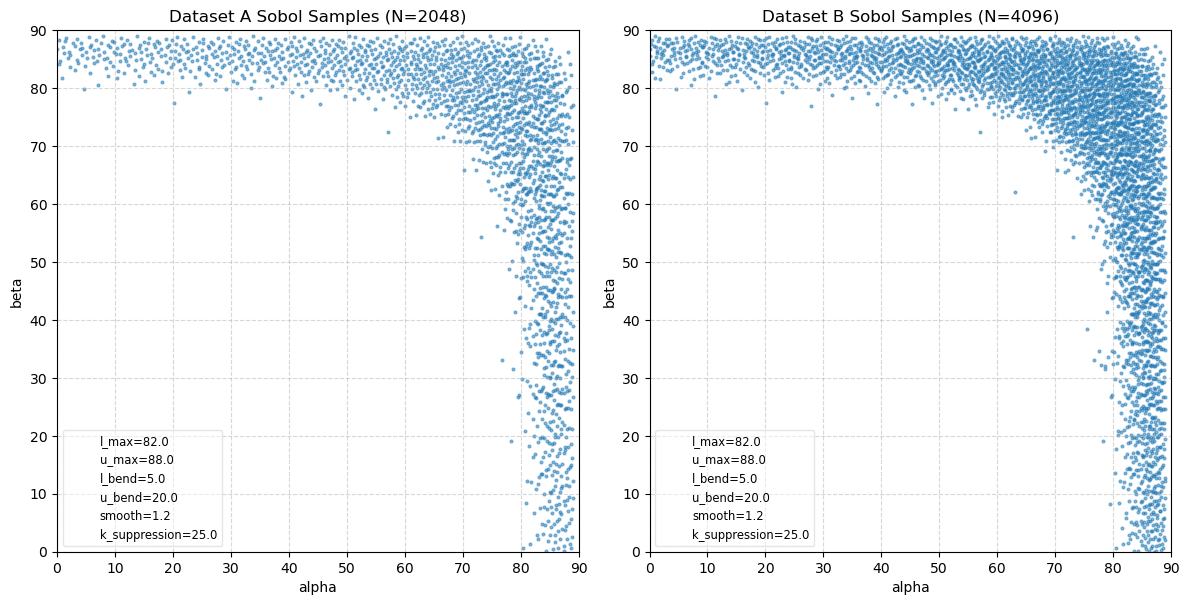

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.stats import qmc

def sample_sobol_from_pdf(params, N=2048, seed=42):
    # Unpack parameters
    l_max, u_max = params["l_max"], params["u_max"]
    l_bend, u_bend = params["l_bend"], params["u_bend"]
    smooth, k_suppression = params["smooth"], params["k_suppression"]

    # Set up grid
    n = 500
    x = np.linspace(0, 89, n)
    y = np.linspace(0, 89, n)
    X, Y = np.meshgrid(x, y, indexing="xy")
    dx, dy = x[1] - x[0], y[1] - y[0]

    # Define superellipse curves
    def lower_curve(t):
        r = np.clip(t / l_max, 0, 1)
        return l_max * (1 - r**l_bend) ** (1 / l_bend)

    def upper_curve(t):
        r = np.clip(t / u_max, 0, 1)
        return u_max * (1 - r**u_bend) ** (1 / u_bend)

    # Compute signed distance field
    mask = (
        (Y >= lower_curve(X)) &
        (Y <= upper_curve(X)) &
        (X >= lower_curve(Y)) &
        (X <= upper_curve(Y))
    )
    dist_in  = distance_transform_edt(mask,    sampling=(dy, dx))
    dist_out = distance_transform_edt(~mask, sampling=(dy, dx))
    signed_d = dist_in - dist_out

    # Logistic smoothing and suppression
    weights = 1.0 / (1.0 + np.exp(-signed_d / smooth))
    alpha_norm = X / X.max()
    beta_norm  = Y / Y.max()
    small = np.minimum(alpha_norm, beta_norm)
    large = np.maximum(alpha_norm, beta_norm)
    suppression = 1 - (1 - small) * (1 - large**k_suppression)
    weights *= suppression

    # Normalize to PDF
    area = np.trapz(np.trapz(weights, y, axis=0), x)
    pdf  = weights / area

    # Precompute CDFs
    f_x = np.trapz(pdf, y, axis=0)
    cdf_x = np.cumsum(f_x) * dx
    cdf_x /= cdf_x[-1]
    cdf_y = np.cumsum(pdf, axis=0) * dy
    cdf_y /= cdf_y[-1, :]

    # Sobol sampling in 2D
    sobol = qmc.Sobol(d=2, scramble=True, seed=seed)
    u_sobol = sobol.random(N)
    ix_s    = np.searchsorted(cdf_x, u_sobol[:, 0], side="right")
    x_sobol = x[ix_s]
    y_sobol = np.array([
        np.interp(u_sobol[i, 1], cdf_y[:, ix_s[i]], y)
        for i in range(N)
    ])
    return x_sobol, y_sobol

# Dataset parameter set (A and B share these)
params_A = {
    "l_max": 82.0,
    "u_max": 88.0,
    "l_bend": 5.0,
    "u_bend": 20.0,
    "smooth": 1.2,
    "k_suppression": 25.0
}

# Generate samples
N_A = 2048
N_B = 2 * N_A  # double the points for Dataset B
xs_A, ys_A = sample_sobol_from_pdf(params_A, N_A, seed=42)
xs_B, ys_B = sample_sobol_from_pdf(params_A, N_B, seed=42)

# Plotting
plt.figure(figsize=(12, 6))

# Dataset A
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(xs_A, ys_A, s=4, alpha=0.5)
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_aspect("equal")
ax1.set_xlabel("alpha")
ax1.set_ylabel("beta")
ax1.set_title(f"Dataset A Sobol Samples (N={N_A})")
ax1.grid(True, linestyle="--", alpha=0.5)
for k, v in params_A.items():
    ax1.plot([], [], " ", label=f"{k}={v}")
ax1.legend(loc="lower left", fontsize="small", framealpha=0.5)

# Dataset B
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(xs_B, ys_B, s=4, alpha=0.5)
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 90)
ax2.set_aspect("equal")
ax2.set_xlabel("alpha")
ax2.set_ylabel("beta")
ax2.set_title(f"Dataset B Sobol Samples (N={N_B})")
ax2.grid(True, linestyle="--", alpha=0.5)
for k, v in params_A.items():
    ax2.plot([], [], " ", label=f"{k}={v}")
ax2.legend(loc="lower left", fontsize="small", framealpha=0.5)

plt.tight_layout()
plt.show()


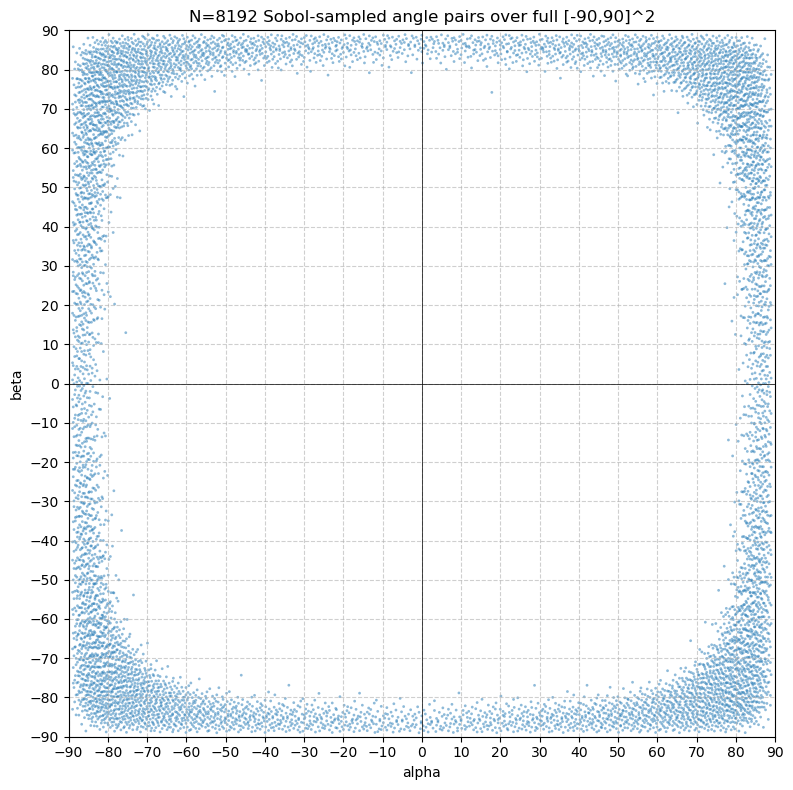

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.stats import qmc
seed = 42
# parameters
l_max, u_max = 82.0, 88.0
l_bend, u_bend = 5.0, 20.0
smooth = 1.2
k_suppression = 25.0
N = 8192  # total number of samples
m_power = int(np.log2(N))

# grid
n = 500
x = np.linspace(0, 89, n)
y = np.linspace(0, 89, n)
X, Y = np.meshgrid(x, y, indexing="xy")


# curves
def lower_curve(t):
    r = np.clip(t / l_max, 0, 1)
    return l_max * (1 - r**l_bend) ** (1 / l_bend)


def upper_curve(t):
    r = np.clip(t / u_max, 0, 1)
    return u_max * (1 - r**u_bend) ** (1 / u_bend)

mask = (Y >= lower_curve(X)) & (Y <= upper_curve(X)) & (X >= lower_curve(Y)) & (X <= upper_curve(Y))
dx, dy = x[1] - x[0], y[1] - y[0]
d_in = distance_transform_edt(mask, sampling=(dy, dx))
d_out = distance_transform_edt(~mask, sampling=(dy, dx))
signed_d = d_in - d_out
weights = 1 / (1 + np.exp(-signed_d / smooth))

# corner suppression
alpha_norm = X / X.max()
beta_norm = Y / Y.max()
small = np.minimum(alpha_norm, beta_norm)
large = np.maximum(alpha_norm, beta_norm)
suppression = 1 - (1 - small) * (1 - large**k_suppression)
weights *= suppression

# normalize to PDF
area = np.trapz(np.trapz(weights, y, axis=0), x)
pdf = weights / area

# marginal and conditional CDFs
f_x = np.trapz(pdf, y, axis=0)
cdf_x = np.cumsum(f_x) * dx
cdf_x /= cdf_x[-1]
cdf_y = np.cumsum(pdf, axis=0) * dy
cdf_y /= cdf_y[-1, :]

# Sobol sampling in four quadrants
sobol = qmc.Sobol(d=3, scramble=True, seed=42)
u = sobol.random_base2(m=m_power)
u0, u1, u2 = u[:, 0], u[:, 1], u[:, 2]
region_id = np.minimum((u2 * 4).astype(int), 3)

ix = np.searchsorted(cdf_x, u0, side="right")
a = x[ix]
b = np.array([np.interp(u1[i], cdf_y[:, ix[i]], y) for i in range(N)])

sx = np.where((region_id & 1) == 0, 1, -1)
sy = np.where((region_id & 2) == 0, 1, -1)
alpha_all = sx * a
beta_all = sy * b

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(alpha_all, beta_all, s=4, alpha=0.5, edgecolor="none")
plt.axhline(0, color="k", linewidth=0.5)
plt.axvline(0, color="k", linewidth=0.5)
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.gca().set_aspect("equal")
plt.xticks(np.arange(-90, 91, 10))
plt.yticks(np.arange(-90, 91, 10))
plt.xlabel("alpha")
plt.ylabel("beta")
plt.grid(True, linestyle="--", alpha=0.6)
plt.title(f"N={N} Sobol-sampled angle pairs over full [-90,90]^2")
plt.tight_layout()
plt.show()